In [ ]:
# Which public health factors have the greatest impact on life expectancy by country 

In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import math
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
import plot_module as plm

In [2]:
df = pd.read_csv('refined_life_expect.csv')
print(df.shape)

#remove fragmanted data
df.dropna(inplace=True)

# make sure that there's still enough data to work with
print(df.shape)

(2938, 19)
(1649, 19)


In [ ]:
# check for correlations between the different variables
sns.pairplot(df, diag_kind="kde", height=2.5)
# plt.savefig('pairedplots_all.png')

In [3]:
# from the paired plot using the columns we believe alcohol, bmi, hiv, gdp, 
# children malnutrition, average education, country size (small/medium/big), 
# the ratio between adult to infant mortality, the interactions between bmi+alcohol (lifestyle), 
# and the interaction between population+gdp might effect the life expectancy

new_df = pd.DataFrame({'life_expectancy': df['life_expectancy'],
                        'alcohol': df['alcohol'],
                        'bmi': df['bmi'],
                        'hiv': df['hiv'],
                        'gdp': df['gdp'],
                        'thinness_till19': df['thinness_till19'],
                        'inf_death': df['inf_death'],
                        'school': df['school'],
                        'death_ratio': df['death_ratio'],
                        'lifestyle': df['bmi']*df['alcohol'],
                        'pop_gdp': df['gdp']*df['pop_size'],
                        'pop_size': df['pop_size'],
                        })

# check for multicollinearity and remove highgly correlated variables
corr_map = new_df.corr()
# corr_map

,life_expectancy,alcohol,bmi,hiv,gdp,thinness_till19,inf_death,school,death_ratio,lifestyle,pop_gdp,pop_size
life_expectancy,1.000000,0.402718,0.542042,-0.592236,0.441322,-0.457838,-0.168080,0.727630,0.077242,0.492554,0.437772,0.071982
alcohol,0.402718,1.000000,0.353396,-0.027113,0.443433,-0.403755,-0.105427,0.616975,0.155647,0.873176,0.435266,0.008297
bmi,0.542042,0.353396,1.000000,-0.210897,0.266114,-0.547018,-0.233732,0.554844,0.140209,0.637528,0.266657,0.024903
hiv,-0.592236,-0.027113,-0.210897,1.000000,-0.108081,0.172592,0.007125,-0.211840,0.044856,-0.118725,-0.106273,-0.011360
gdp,0.441322,0.443433,0.266114,-0.108081,1.000000,-0.277498,-0.097386,0.467947,0.021057,0.453037,0.982121,0.024251
thinness_till19,-0.457838,-0.403755,-0.547018,0.172592,-0.277498,1.000000,0.462942,-0.491199,-0.111875,-0.446647,-0.274995,-0.027288
inf_death,-0.168080,-0.105427,-0.233732,0.007125,-0.097386,0.462942,1.000000,-0.213482,-0.213483,-0.152389,-0.094019,0.078594
school,0.727630,0.616975,0.554844,-0.211840,0.467947,-0.491199,-0.213482,1.000000,0.160053,0.641943,0.462242,0.023520
death_ratio,0.077242,0.155647,0.140209,0.044856,0.021057,-0.111875,-0.213483,0.160053,1.000000,0.151421,0.008479,-0.114006
lifestyle,0.492554,0.873176,0.637528,-0.118725,0.453037,-0.446647,-0.152389,0.641943,0.151421,1.000000,0.449248,-0.002239


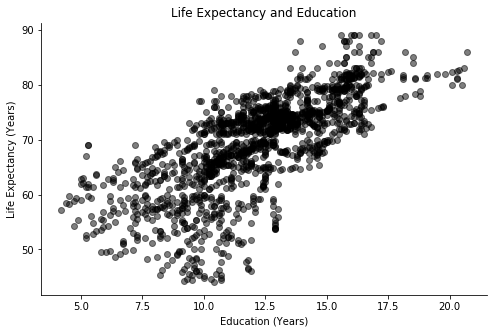

In [4]:
# Example 1: Correlation between average education and life expectancy
plm.create_scatter(new_df['school'], new_df['life_expectancy'], 'Life Expectancy and Education', 
                   'Education (Years)', 'Life Expectancy (Years)')         
# np.corrcoef(new_df['school'], new_df['life_expectancy'])

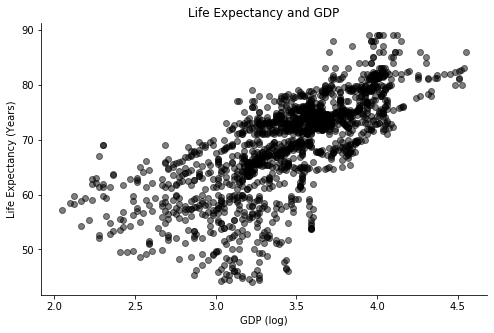

In [5]:
# Example 2: Correlation between log transformed value of GDP and life expectancy
plm.create_scatter(np.sqrt(new_df['school']), new_df['life_expectancy'], 'Life Expectancy and GDP', 
                   'GDP (log)', 'Life Expectancy (Years)') 
# plt.savefig('inf_death_sbrt.png')

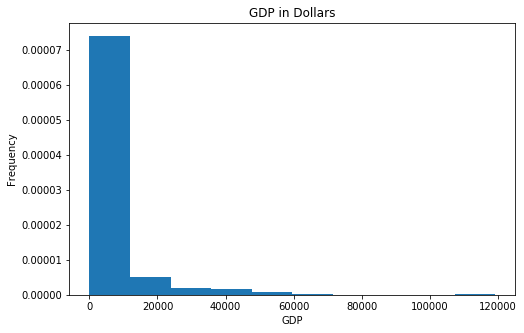

In [13]:
plm.create_hist(new_df['gdp'], title="GDP in Dollars", xlabel="GDP") 

In [ ]:
# Create a heatmap for all our variables
plm.CorrMtx(corr_map)

In [ ]:
# before running the model we looked at our data more closely to check for outliers
depended = ['life_expectancy']
features = ['school', 'hiv', 'thinness_till19', 'gdp',
            'death_ratio', 'inf_death', 'pop_gdp', 'bmi',
            'alcohol', 'lifestyle'] 

# looking at our data again to try and locate outliers
plm.get_pairs(new_df, depended, features, 3)
new_df.shape

In [ ]:
# transform our independent variable to look more normally distrubuted
new_df.hiv = new_df['hiv'].apply(np.log)
new_df.pop_gdp = new_df['pop_gdp'].apply(np.log)
new_df.gdp = new_df['gdp'].apply(np.log)
new_df.inf_death =new_df['inf_death'].apply(np.cbrt)
new_df.death_ratio = new_df['death_ratio'].apply(np.sqrt)

In [ ]:
# remove outliers and check the amount of data that we left
new_df = new_df[new_df.gdp > 1.25] 
new_df = new_df[new_df.thinness_till19 < 25]
new_df = new_df[new_df.lifestyle < 1000]

plm.get_pairs(new_df, depended, features, 3)
new_df.shape

In [ ]:
# Using seaborn to create scatters and distribution graphs for our possible predictors after transforming the data
colors = ['red','blue','green','black','purple','orange','pink', 'cyan','maroon', 'gray']
count = 0 
for column in new_df.columns[1:-1]:
    plots = sns.jointplot(x=column, y='life_expectancy', data=new_df, kind='reg', ylim=(0,140), color=colors[count])
    plots.annotate(stats.pearsonr)
    count += 1

In [ ]:
# first model to test our feature's significance
lr_model_init = ols(formula='life_expectancy~bmi+hiv+gdp+thinness_till19+inf_death+C(pop_size)+school+death_ratio+lifestyle+pop_gdp', data=new_df).fit()
lr_model_init.summary()

In [ ]:
 plm.checkresiduals(new_df, 'life_expectancy', lr_model_init)

In [ ]:
#adjusting the model - remove features that were not statistically significant (alcohol, bmi, lifestyle)
lr_model_inter = ols(formula='life_expectancy~+hiv+gdp+thinness_till19+inf_death+school+death_ratio+pop_gdp+C(pop_size)', data=new_df).fit()
lr_model_inter.summary()

In [ ]:
plm.checkresiduals(new_df, 'life_expectancy', lr_model_inter)

In [ ]:
# Scaling the data set
independent = ['school', 'hiv', 'thinness_till19',
               'death_ratio', 'inf_death', 'pop_gdp',
               'gdp', 'pop_size'] 

scaler = StandardScaler()
scaler.fit(new_df[independent])
scaled_features = scaler.transform(new_df[independent])

# create a scaled dataframe
scaled_features_df = pd.DataFrame(scaled_features, columns=independent, index=new_df.index)
scaled_features_df.head()

# running the model again
scaled_features_model = sm.OLS(endog=new_df['life_expectancy'], exog=sm.add_constant(scaled_features_df)).fit()
scaled_features_model.summary()

In [ ]:
plm.checkresiduals(new_df, 'life_expectancy', scaled_features_model)

In [ ]:
# removing bmi, gdp, population size from testing that were deemed insignificant in past models
X = new_df[['hiv','pop_gdp', 'death_ratio','school', 'thinness_till19', 'inf_death',]].values
y = new_df.life_expectancy.values.reshape(-1,1)

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
model = LinearRegression()
model.fit(x_train, y_train)
# print(model.intercept_)
# print(model.coef_)

y_predict = model.predict(x_test)
predict_df = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_predict.flatten()})
plot_df = predict_df.head(1530)
# plot_df.plot(kind='scatter', x='Actual', y='Predicted', figsize=(8,5))
# plt.ylabel('Life Expectancy')
# plt.xlabel('Obvservation')

plm.create_scatter(plot_df.Actual, plot_df.Predicted, 'title', 'xlabel', 'ylabel')

print('Mean absolete error:', metrics.mean_absolute_error(y_test, y_predict))
print('Mean squared error:', metrics.mean_squared_error(y_test, y_predict))
print('Root squared error:', np.sqrt(metrics.mean_squared_error(y_test, y_predict)))

In [ ]:
# adding the features that were considered insignificant to our model to test
X2 = new_df[['alcohol','bmi', 'pop_size', 'hiv','pop_gdp', 'death_ratio','school', 'thinness_till19', 'inf_death',]].values
y2 = new_df.life_expectancy.values.reshape(-1,1)

x_train2, x_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.2, random_state=0)
model = LinearRegression()
model.fit(x_train2, y_train2)
# print(model.intercept_)
# print(model.coef_)

y_predict2 = model.predict(x_test2)
predict_df2 = pd.DataFrame({'actual': y_test2.flatten(), 'predicted': y_predict2.flatten()})
plot_df2 = predict_df2.head(5)
plot_df2.plot(kind='bar', figsize=(8,5))
plt.ylabel('Life Expectancy')
plt.xlabel('Obvservation')


print('Mean absolete error:', metrics.mean_absolute_error(y_test2, y_predict2))
print('Mean squared error:', metrics.mean_squared_error(y_test2, y_predict2))
print('Moot squared error:', np.sqrt(metrics.mean_squared_error(y_test2, y_predict2)))